# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Sahar | Yousefi  | Sahar Yousefi, 11/08/2024| 10 Hours |  25% |
| Member 2: | Wedeb | Teweldemedhin | Wedeb Teweldemedhin, 11/08/2024 | 10 Hours | 25% |
| Member 3: | Bahram | Akbari | Bahram Akbari, 11/08/2024 | 10 Hours | 25% |
| Member 4: | Nishesh | Nepal  | Nishesh Nepal, 11/08/2024 | 10 Hours | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

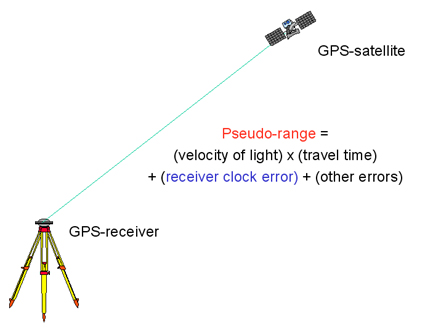

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 0.2: Read and parse data files

In [26]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [27]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [28]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [29]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [30]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    rho = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = rho - cdT
    residuals = pseudorange - predicted_pseudorange
    L = np.sum(residuals**2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [31]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient_function(r_pos, cdT, s_pos, pseudorange):
    rho = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = rho - cdT
    residuals = pseudorange - predicted_pseudorange

    diff_pos = r_pos - s_pos
    grad_pos = -np.sum((residuals[:, None] * diff_pos) / rho[:, None], axis=0)
    grad_cdT = np.sum(residuals)
    grad = np.hstack((grad_pos, grad_cdT))

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [32]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, sat_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, sat_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient_function(r_pos, cdT, sat_pos, pseudorange)

        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], sat_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [33]:
# Run gradient descent optimization
optimized_params = gradient_descent(pseudorange, sat_pos)

# Extract optimized position and clock offset
optimized_position = optimized_params[:3]
optimized_cdT = optimized_params[3]

# Calculate final position error relative to the GroundTruth
final_position_error = optimized_position - GroundTruth

# Calculate final cost using the optimized parameters
final_cost = cost_function(optimized_position, optimized_cdT, sat_pos, pseudorange)

# Calculate final gradient using the optimized parameters
final_gradient = gradient_function(optimized_position, optimized_cdT, sat_pos, pseudorange)

# print the mentioned metrics
print("Optimized parameters:", optimized_params)
print("Final position errors of receiver:", final_position_error)
print("Number of steps taken for convergence:", steps_count)
print("Final cost value:", final_cost)
print("Final gradient values:", final_gradient)

Converged !
Optimized parameters: [-1.63349244e+06 -3.65162954e+06  4.95248543e+06 -6.46899086e+00]
Final position errors of receiver: [-3.06452823 -2.35814083  3.80782687]
Number of steps taken for convergence: 588
Final cost value: 6.1970361882315945
Final gradient values: [ 0.00010866  0.00060547 -0.00186084  0.00105501]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

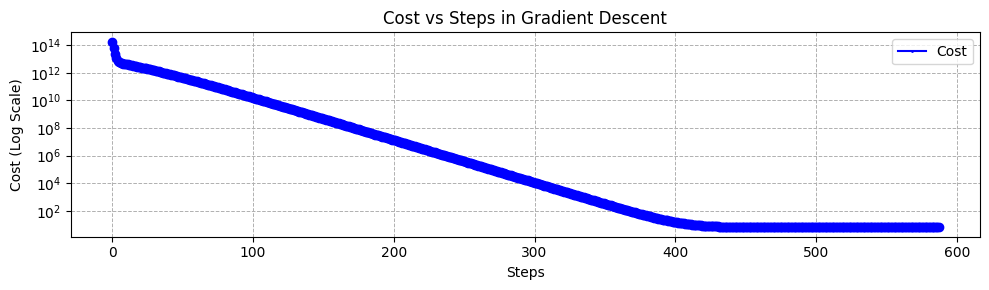

In [34]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

# Plot cost vs steps using semilogy for a logarithmic scale on the y-axis
ax.plot(arr_cost, marker='o', linestyle='-', color='b', markersize=1, label='Cost')

# Plot with logarithmic y-axis
ax.semilogy(arr_cost, marker='o', linestyle='-', color='b')

# Setting title and labels
ax.set_title('Cost vs Steps in Gradient Descent')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost (Log Scale)')

# Add a legend
ax.legend()

# Improve grid visibility
ax.grid(True, which='both', linestyle='--', linewidth=0.7)

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

# Comment on the pattern
# In the Cost vs Steps plot, the cost typically decreases with each step,
# showing the convergence behavior of the gradient descent algorithm.
#
# Pattern: Generally, the plot should show a downward trend, with the cost
# reducing gradually over each iteration, eventually stabilizing as it converges.
# This implies that the algorithm is learning and moving towards a minimum point
# in the cost function.
#
# Analysis: If the plot exhibits fluctuations or sudden jumps, it could indicate
# too high a learning rate, potentially causing the model to oscillate.
# Alternatively, if the cost decreases very slowly, the learning rate might be
# too low, leading to slow convergence.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

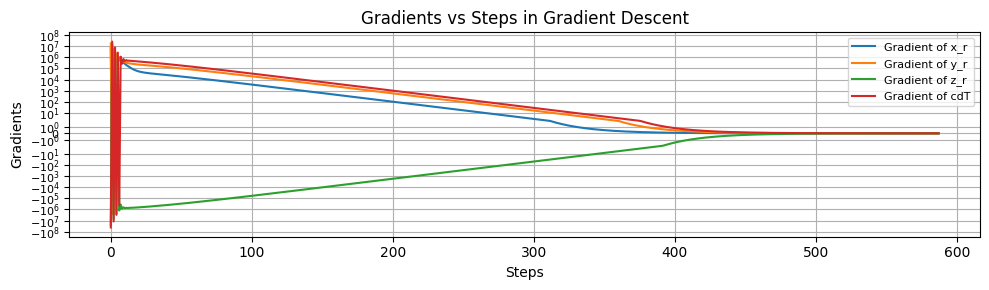

In [35]:
# Unpack gradients for better readability
x_grad = np.array([g[0] for g in arr_grad])  # Gradient for x_r
y_grad = np.array([g[1] for g in arr_grad])  # Gradient for y_r
z_grad = np.array([g[2] for g in arr_grad])  # Gradient for z_r
cdT_grad = np.array([g[3] for g in arr_grad])  # Gradient for cdT

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

ax.plot(x_grad, label='Gradient of x_r')
ax.plot(y_grad, label='Gradient of y_r')
ax.plot(z_grad, label='Gradient of z_r')
ax.plot(cdT_grad, label='Gradient of cdT')

ax.set_yscale('symlog')
ax.set_xlabel('Steps', fontsize=10)
ax.set_ylabel('Gradients', fontsize=10)
ax.set_title('Gradients vs Steps in Gradient Descent', fontsize=12)
ax.tick_params(axis='y', labelsize=8)
ax.legend(fontsize=8)
ax.grid(True)

fig.tight_layout()
plt.show()

# Comment on the pattern
# As the iterations progress, the gradients for each parameter are expected to decrease,
# indicating that the algorithm is converging towards a minimum cost.
# If the gradients reach a very small magnitude, this suggests that the updates are becoming minimal,
# which may indicate convergence. Additionally, if the gradients fluctuate significantly,
# it might be worth considering adjustments to the learning rate or further analysis of the optimization path.


### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

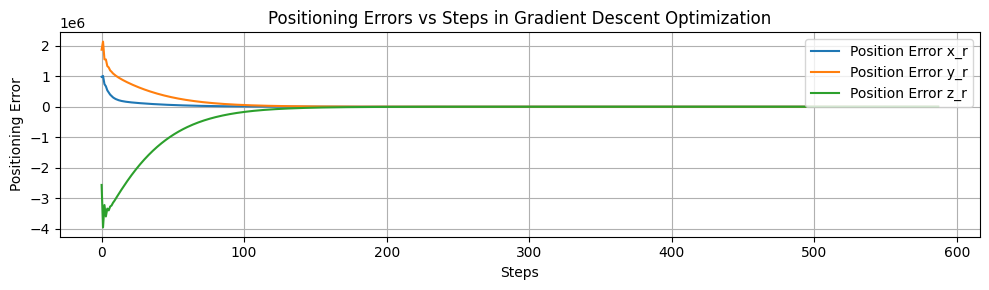

In [36]:
arr_err = np.array(arr_err)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

ax.plot(arr_err[:, 0], label='Position Error x_r')
ax.plot(arr_err[:, 1], label='Position Error y_r')
ax.plot(arr_err[:, 2], label='Position Error z_r')

ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error')
ax.set_title('Positioning Errors vs Steps in Gradient Descent Optimization')
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()

# Comment on the pattern
# The positioning errors generally decrease as the number of steps increases, indicating that the algorithm
# is successfully reducing the error in the estimated position. Initially, the errors may fluctuate or be large,
# but as steps progress, they tend to decrease and stabilize, which suggests that the optimization
# algorithm is converging towards an accurate solution



# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [37]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01)

optimized_position_2 = optimized_params_2[:3]
optimized_cdT_2 = optimized_params_2[3]

final_position_error = optimized_position_2 - GroundTruth

final_cost = cost_function(optimized_position_2, optimized_cdT_2, sat_pos, pseudorange)

final_gradient = gradient_function(optimized_position_2, optimized_cdT_2, sat_pos, pseudorange)

print("Optimized parameters:", optimized_params_2)
print("Final position errors of receiver:", final_position_error)
print("Number of steps taken for convergence:", steps_count)
print("Final cost value:", final_cost)
print("Final gradient values:", final_gradient)


Converged !
Optimized parameters: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06 -6.46239527e+00]
Final position errors of receiver: [-3.06384888 -2.3543555   3.79619298]
Number of steps taken for convergence: 5652
Final cost value: 6.197165698416758
Final gradient values: [ 0.00034574  0.00192647 -0.00592083  0.00335672]


In [38]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001)

optimized_position_3 = optimized_params_3[:3]
optimized_cdT_3 = optimized_params_3[3]

final_position_error = optimized_position_3 - GroundTruth

final_cost = cost_function(optimized_position_3, optimized_cdT_3, sat_pos, pseudorange)

final_gradient = gradient_function(optimized_position_3, optimized_cdT_3, sat_pos, pseudorange)

print("Optimized parameters:", optimized_params_3)
print("Final position errors of receiver:", final_position_error)
print("Number of steps taken for convergence:", steps_count)
print("Final cost value:", final_cost)
print("Final gradient values:", final_gradient)

Optimized parameters: [-1622126.12222408 -3588680.62330238  4759183.15248715   110181.78568974]
Final position errors of receiver: [  11363.25745317   62946.55920125 -193298.46706203]
Number of steps taken for convergence: 0
Final cost value: 18483476837.77236
Final gradient values: [  3917.59641257  21568.21237973 -66176.30035364  37926.58995917]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)
**Answer for Q1:** With a learning rate of 0.1, the model takes larger steps in each iteration. This means the model converges to a local minimum more quickly, reaching it in 588 iterations in our experiment. However, with a learning rate of 0.01, the number of iterations required to reach a local minimum increases to 5652. The extremely small learning rate of 0.001 has hindered the model's ability to converge. The model's updates are so tiny that it cannot effectively escape local minima or navigate the optimization landscape, leading to a complete failure to converge.

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)
**Answer for Q2:** The difference between Least Squares Estimation (LSE) and Gradient Descent lies in their approach to optimization and their impact on results. LSE provides a direct, analytical solution to the optimization problem by minimizing the sum of squared residuals, leading to an exact solution for linear relationships without needing iteration. In contrast, Gradient Descent is an iterative method that gradually adjusts the parameters by calculating the gradient of the loss function. This iterative nature makes Gradient Descent more suitable for large datasets and non-linear models, though it requires tuning the learning rate to ensure convergence. In terms of results, LSE was faster and precise for linear regression, while Gradient Descent required careful management of the learning rate to converge effectively, demonstrating its flexibility at the cost of stability.


---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [40]:
!pip install ucimlrepo

In [41]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = pd.DataFrame(phishing_websites.data.features)
y = pd.DataFrame(phishing_websites.data.targets)

# TO DO: display sizes of X and y (1 mark)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (11055, 30)
Shape of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

Class distribution:
 result
 1    6157
-1    4898
Name: count, dtype: int64


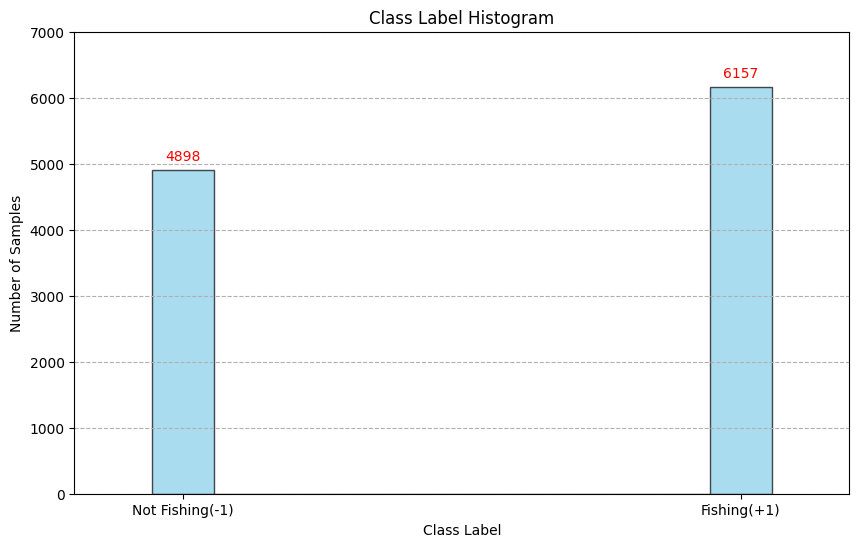

In [42]:
# TO DO: Check the class distribution of y (2 mark)

# Assuming 'result' is the name of the column in your DataFrame 'y'
class_distribution = y['result'].value_counts()
print("Class distribution:\n", class_distribution)

# Display exact values for each bin in the histogram

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(y['result'],color='skyblue', edgecolor='black', alpha=0.7)
bin_centers = (0.9, -0.9)

# Display exact values for each bin
for count, x in zip(class_distribution, bin_centers):
    plt.text(x, count +100, str(count), color= 'red', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Label Histogram')
plt.grid(axis='y', linestyle='--')
plt.xticks([0.9, -0.9], ['Fishing(+1)','Not Fishing(-1)'])
plt.xlim(-1.25, 1.25)
plt.ylim(0,7000)

# Show the plot
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [47]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split

X_train, X_small, y_train, y_small = train_test_split(X, y, test_size=0.03, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Shape of X_small:", X_small.shape)
print("Shape of y_small:", y_small.shape)

Shape of X_small: (332, 30)
Shape of y_small: (332, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [48]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler

# Model evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    log_loss_value = log_loss(y_test, model.predict_proba(X_test))
    data_size = len(X_train) + len(X_test)
    num_training_samples = len(X_train)
    num_testing_samples = len(X_test)
    return data_size, num_training_samples, num_testing_samples, train_accuracy, test_accuracy, log_loss_value

# Prepare results DataFrame
results_df = pd.DataFrame(columns=["Data size", "Training samples", "Testing samples", "Training accuracy", "Testing accuracy", "Log loss"])

# Full dataset evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_full = LogisticRegression(max_iter=2000).fit(X_train, y_train)
results_df.loc['Full Dataset'] = evaluate_model(model_full, X_train, y_train, X_test, y_test)

# First two columns of X
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X.iloc[:, :2], y, test_size=0.3, random_state=42)
model_subset = LogisticRegression(max_iter=2000).fit(X_train_subset, y_train_subset)
results_df.loc['Two-Column Dataset'] = evaluate_model(model_subset, X_train_subset, y_train_subset, X_test_subset, y_test_subset)

# Small dataset evaluation
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.3, random_state=42)
model_small = LogisticRegression(max_iter=2000).fit(X_train_small, y_train_small)
results_df.loc['Small Dataset'] = evaluate_model(model_small, X_train_small, y_train_small, X_test_small, y_test_small)

# Print results
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                    Data size  Training samples  Testing samples  \
Full Dataset          11055.0            7738.0           3317.0   
Two-Column Dataset    11055.0            7738.0           3317.0   
Small Dataset           332.0             232.0            100.0   

                    Training accuracy  Testing accuracy  Log loss  
Full Dataset                 0.931119          0.921917  0.187942  
Two-Column Dataset           0.554019          0.577329  0.677354  
Small Dataset                0.961207          0.950000  0.147955  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [45]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [46]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

NameError: name 'conf_mat' is not defined

In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---